# Stationary multi-armed bandit

In the stationary case the reward probability $p_{t, l}$ is fixed, hence $p_{t,l} = p_l$, $ \forall t \in \{1, T\}$. We will consider here the variant of the problem in which all but the best arm have the same reward probability $p=1/2$, and the reward probability of the 'best' arm is set as $p_{max} = p + \epsilon$, where $\epsilon \in \left(0, \frac{1}{2}\right]$.

In [1]:
# define the generative process for rewards and outcomes with zero change probability
from jax import devices
devices(backend='cpu')

import numpy as np
import jax.numpy as jnp
from jax import random, lax, nn, ops, vmap, jit

rho = .0 # change probability

log_pj_j = jnp.log(np.array([[1 - rho, rho], [1, 0]]))

def process(t, choices, states, rng_key):
    probs, changes = states
    
    N = len(choices)
    K = len(probs)
    
    rng_key, _rng_key = random.split(rng_key)
    new_change = random.categorical(_rng_key, log_pj_j[changes])
    
    rng_key, _rng_key = random.split(rng_key)
    random_probs = random.uniform(_rng_key, shape=(K,))
    
    new_probs = jnp.where(new_change, random_probs, probs)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs, shape=(N, K))
    
    return outcomes, [new_probs, new_change]

/mnt/data/miniconda/envs/numpyro/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Bayesian inference

Given the constrain of this investigation to the Bernoulli bandits we will define the observation likelihood as 

$$ p(o_t|\vec{\theta}, k_t) = \prod_{k=1}^K \left[ \theta_k^{o_{t}}\left( 1- \theta_k \right)^{1-o_{t}} \right]^{\delta_{k_t, k}}  $$

In both cases we can assume that the prior over reward probabilities is given as the product of conjugate priors of the Bernoulli distribution, that is, the Beta distribution. Hence,

$$ p(\vec{\theta}|k_t) = \prod_{k=1}^K \left[ B(\theta_k; \alpha_{0,k}, \beta_{0,k}) \right]^{\delta_{k_t, k}}$$

where we assume that initial prior (before making any observations) corresponds to a uniform distribution, 
hence $\alpha_{0,k}, \beta_{0,k} = 1, \forall \: k$. Conjugacy of the prior allows us to define simple update rules

\begin{equation}
    \begin{split}
    \alpha_{t, k} &= \alpha_{t-1, k} + \delta_{k_t, k} o_t \\
    \beta_{t, k} &= \beta_{t-1,k} + \delta_{k_t, k} (1-o_t)
    \end{split}
\end{equation}

where the parameter update is performed only for a selected $k$th arm at trial $t$.

In [2]:
# define the learning rule
def learning(outcomes, choices, priors):
    
    N, K = outcomes.shape
    
    select_observed = jnp.eye(K)[choices]
    
    alpha_t = priors[..., 0] + select_observed * outcomes
    beta_t = priors[..., 1] + select_observed * (1 - outcomes)
        
    return jnp.stack([alpha_t, beta_t], -1)

## Action selection

### Thompson sampling

This form of action selection algorithm is derived from the i.i.d samples from the reward probability prior
at trial $t$, hence

$$a_t = \arg\max_k \theta^*_k, \qquad \theta^*_k \sim Beta(\theta_k; \alpha_{t-1, k}, \beta_{t-1, k})$$

An extension of this often found in the literature, specially on dynamic MABs, is called optimistic 
Thompson sampling, and is defined as 

$$a_t = \arg\max_k \max(\theta^*_k, \mu_{t-1,k}), \qquad \theta^*_k \sim Beta(\theta_k; \alpha_{t-1, k}, \beta_{t-1, k})$$

where the expected reward probability $\mu_{t-1, k} = \frac{\alpha_{t-1,k}}{\alpha_{t-1,k} + \beta_{t-1, k} }$
constrains the minimal value of the sample from the prior.


### Upper confidence bound (UCB)

Another classical algorithm of reinforcement learning with a decision rule defined as

\begin{equation}
    a_t = \left\{ \begin{array}{cc}
        \arg\max_k \left(\mu_{k, t-1} + \sqrt{\frac{2 \ln t}{\nu_{k, t-1}-2}}\right) & \textrm{for } t>K \\
        t & \textrm{otherwise}
    \end{array}
    \right.
\end{equation}

where $\mu_{k, t-1} = \frac{\alpha_{t-1, k}}{\nu_{t-1, k}}$ and $\nu_{k, t-1} = \alpha_{t-1,k} + \beta_{t-1,k}$.

### Active inference

The action selection in active inference rest upon the expected free energy $G(\pi)$ of behavioral policy $\pi$. Normally, behavioral policies in active inference correspond to a specific sequence of future actions $\pi = (a_{t}, \ldots, a_D)$ up to some planning depth $D$. Here we will limit the analysis to a shallow planning depth of $D=1$ hence each policy corresponds to one of the possible choices, that is actions $a_t$.
The expected free energy is defined as 

$$ G(a_t) = D_{KL}\left(Q(\vec{\theta}, k_t |a_t)||P(\vec{\theta}, k_t)\right) + E_{Q(\vec{\theta}, k_{t}|a_t)}\left[H[o_t|\vec{\theta}, k_t] \right]$$

where $P(\vec{\theta}, k_t)$ corresponds to a prior preference over hidden states, and $Q(\vec{\theta}, k_t |a_t)$ to the action dependent expectation in trial $t$, hence

$$Q(\vec{\theta}, k_t |a_t) = p(\theta|k_t, o_{1:t-1}) p(k_t|a_t) $$

The expected free energy forms an upper bound on the expected surprisial $S(a_t)$ defined as

\begin{equation}
    \begin{split}
    S(a_t) & =  D_{KL}\left(Q(o_t |a_t)||P(o_t)\right) + E_{Q(\vec{\theta}, k_{t}|a_t)}\left[H[o_t|\vec{\theta}, k_t] \right] \\
    & = - E_{Q(o_t|a_t)}\left[ \ln P(o_t) +  D_{KL}\left( Q(\vec{\theta}, k_t|o_t, a_t)|| Q(\vec{\theta}, k_t|a_t)\right) \right] \leq G(a_t)
    \end{split}
\end{equation}


where 

$$Q(o_t|a_t) = \sum_{k_t} \int d \vec{\theta} p(o_t|\vec{\theta}, k_t) Q(\vec{\theta}, k_t|a_t),$$ 

and

$$ Q(\vec{\theta}, k_t|o_t, a_t) \propto p(o_t|\vec{\theta}, k_t) Q(\vec{\theta}, k_t|a_t).$$

We will assume that the agent has no preference between arms, hence $P(k_t) = \frac{1}{K}$. However, the agent will prefer higher reward probabilities. We can express this as 

$$ P(\vec{\theta}|k_t) \propto \prod_k \theta_k^{\delta_{k_t, k} \left( \alpha-1 \right)}$$

From the joint preference over arms and reward probabilities we can obtain the marginal preference over outcomes as  

$$ P(o_t) = \sum_{k_t} \int p(o_t|\vec{\theta}, k_t) P(\vec{\theta}, k_t) d \vec{\theta} \propto e^{o_t \lambda} e^{-(1-o_t) \lambda}, \qquad \lambda = \frac{1}{2} \ln \alpha $$

We will consider two variants of the action selection rule: 

* one based on the expected free energy and defined as 
    $$ p(a_t) \propto e^{- \gamma G(a_t)},$$

* and another based on expected surprisal and defined as

    $$ p(a_t) \propto e^{- \gamma S(a_t)}.$$

The motivation for this differentiation comes from the fact that minimum of the expected free energy will not in general correspond to the minimum of the expected surprisal, hence 

$$ \arg\min_a G(a) \neq \arg\min_a S(a)$$

Given the known functional expressions for the prior expectation $Q(\vec{\theta}, k_t| a_t)$, and $Q(o_t| a_t)$ prior preferences $P(\vec{\theta}, k_t)$, and $P(o_t)$, and observation likelihood $p(o_t|\vec{\theta}, k_t)$ we get the following expressions for expected free energy and expected surprisal 

\begin{equation}
    \begin{split}
    G(a_t = a) = & - \ln \left[ B(\alpha_{t-1, a}, \beta_{t-1, a})\right] \\
    & + (\alpha_{t-1, a} - \alpha - \mu_{t-1,a}) \psi(\alpha_{t-1, a}) \\
    & + (\beta_{t-1, a} - 2 + \mu_{t-1, a}) \psi(\beta_{t-1, a}) \\ & + (\alpha + 2 - \nu_{t-1, a}) \psi(\nu_{t-1, a}) - \frac{1}{\nu_{t-1,a}} \\
    S(a_t = a) = & - \lambda( 2 \cdot  \mu_{t-1, a} - 1) + \mu_{t-1, a} \ln \mu_{t-1, a} + (1-\mu_{t-1, a}) \ln ( 1- \mu_{t-1, a}) \\
    & - \mu_{t-1,a} \psi(\alpha_{t-1, a}) - (1 - \mu_{t-1,a}) \psi(\beta_{t-1, a}) + \psi(\nu_{t-1,a}) - \frac{1}{\nu_{t-1,a}} \\
    \approx & -\lambda(2 \mu_{t-1, a} - 1) - \frac{1}{2 \nu_{t-1, a}}
    \end{split}
\end{equation}

In [3]:
# implementation of decision algorithms
from jax.scipy.special import digamma, betaln
from scipy.special import betaincinv

def thompson_selection(t, beliefs, rng_key):
    #Thompson sampling
    
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    thetas = random.beta(rng_key, alpha_t, beta_t)
    
    choices = thetas.argmax(-1) # select choices with maximal outcome probability
    
    return choices

def ots_selection(t, beliefs, rng_key):
    #Optimistic thompson sampling
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    mu_t = alpha_t / (alpha_t + beta_t)
    
    thetas = random.beta(rng_key, alpha_t, beta_t)
    
    choices = jnp.where(thetas > mu_t, thetas, mu_t).argmax(-1) # select choices with maximal outcome probability
    
    return choices

def ucb_selection(t, beliefs, rng_key):
    # classical ucb algorithm
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    N, K = beliefs.shape[:-1]
        
    choices1 = (mu_t + jnp.sqrt(2 * jnp.log(1 + t)/(nu_t-2 + 1e-6))).argmax(-1)
    choices2 = t * np.ones(N, dtype=np.int32)
    
    return np.where(t >= K, choices1, choices2)

def bucb_selection(t, beliefs, rng_key):
    # bayesian ucb algorithm 

    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    perc = 1. - 1./(1. + t)
    Q = betaincinv(alpha_t, beta_t, perc)
    
    return Q.argmax(-1)
    
def G(alpha_t, beta_t, alpha):
    nu_t = alpha_t + beta_t
    mu_t = alpha_t / nu_t
    
    KL_a = - betaln(alpha_t, beta_t) + (alpha_t - alpha) * digamma(alpha_t)\
             + (beta_t - 1) * digamma(beta_t) + (alpha + 1 - nu_t) * digamma(nu_t)
    
    H_a = - mu_t * digamma(alpha_t + 1) - (1-mu_t) * digamma(beta_t + 1) + digamma(nu_t + 1)
    
    return KL_a + H_a

def efe_selection(t, beliefs, rng_key, gamma=10, lam=1.):
    # expected free energy based action selection
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    alpha = jnp.exp(2 * lam)
    
    G_a = G(alpha_t, beta_t, alpha)
    
    choices = random.categorical(rng_key, - gamma * G_a) # sample choices
    return choices

def S(alpha_t, beta_t, lam):
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t / nu_t
    
    KL_a = - lam * (2 * mu_t - 1) + mu_t * jnp.log(mu_t) + (1-mu_t) * jnp.log(1-mu_t) 
    
    H_a = - mu_t * digamma(alpha_t + 1) - (1-mu_t) * digamma(beta_t + 1) + digamma(nu_t + 1)
    
    return KL_a + H_a

def sup_selection(t, beliefs, rng_key, gamma=10., lam=1.):
    # expected surprisal based action selection
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    S_a = S(alpha_t, beta_t, lam) 
    
    choices = random.categorical(rng_key, - gamma * S_a) # sample choices
    return choices

def app_selection(t, beliefs, rng_key, gamma=10., lam=1.):
    # expected surprisal based action selection
    alpha_t = beliefs[..., 0]
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    S_a = - lam * (2 * mu_t - 1) - 1/(2 * nu_t)
    
    choices = random.categorical(rng_key, - gamma * S_a) # sample choices
    return choices

In [4]:
# implement simulator for POMDP
def simulator(process, learning, action_selection, N=100, T=1000, K=10, seed=0, eps=.25):
    def sim_fn(carry, t):
        rng_key, states, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(t, prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, states = process(t, choices, states, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, states, posterior), choices
    
    rng_key = random.PRNGKey(seed)
    probs = jnp.concatenate([jnp.array([eps + .5]), jnp.ones(K-1)/2.])
    states = [probs, jnp.zeros(1, dtype=jnp.int32)]
    prior = jnp.ones((N, K, 2))/2
    
    _, choices = lax.scan(sim_fn, (rng_key, states, prior), jnp.arange(T))
    
    return choices

Before we compare active inference with Thompson sampling and UCB algorithm, we will illustrate how the values of action precision $\gamma$ and the precision of prior preferences $\lambda$ impact cumulative regret of the active inference agent.

In [5]:
from collections import defaultdict
from tqdm.notebook import trange
from jax.interpreters import xla
import itertools

def estimate_regret_rate1(Ks, epsilon, T=10000, N=500):
    mean_reg = defaultdict(lambda: [])

    seed = random.PRNGKey(100)
    gammas = jnp.arange(1., 21., 1.)
    lambdas = jnp.arange(.0, 4., .2)
    
    times = np.arange(1, T+1)[::10, None]

    for i in trange(len(Ks), desc='K loop'):
        K = Ks[i]
        for func, label in zip([efe_selection, sup_selection, app_selection], 
                       ['EFE_K{}'.format(K), 'SUP_K{}'.format(K), 'APP_K{}'.format(K)]):

            seed, _seed = random.split(seed)
            sim = jit(lambda e, g, l: simulator(process, 
                                                learning, 
                                                lambda *args: func(*args, gamma=g, lam=l), 
                                                N=N, T=T, K=K, 
                                                eps=e, 
                                                seed=_seed[0]))
            
            vals = jnp.array(list(itertools.product(gammas, lambdas)))
            
            choices = vmap(lambda g, l: sim(epsilon, g, l))(vals[:, 0], vals[:, 1])
            regret = np.cumsum((1 - (choices == 0).astype(jnp.float32)) * epsilon, -2)[:, ::10]
            mean_reg[label].append(regret/times)
                    
            xla._xla_callable.cache_clear()
                    
    np.savez('res_AI_Ks_e{}'.format(int(epsilon * 100)), **mean_reg)

In [ ]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate1(Ks, epsilon=.1)

In [ ]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate1(Ks, epsilon=.25)

In [ ]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate1(Ks, epsilon=.4)

In [14]:
# implement simulator for POMDP

def scan(func, carry, iterate):
    saves = []
    for n in iterate:
        carry, res = func(carry, n)
        saves.append(res)
    
    return np.stack(saves, 0)

def simulator_bucb(process, learning, action_selection, N=100, T=1000, K=10, seed=0, eps=.25):
    def sim_fn(carry, t):
        rng_key, states, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(t, prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, states = process(t, choices, states, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, states, posterior), choices
    
    rng_key = random.PRNGKey(seed)
    probs = np.concatenate([np.array([eps + .5]), np.ones(K-1)/2.])
    states = [probs, np.zeros(1, dtype=np.int32)]
    prior = np.ones((N, K, 2))/2
    
    choices = scan(sim_fn, (rng_key, states, prior), np.arange(T))
    
    return choices

In [15]:
def estimate_regret_rate2(Ks, epsilon, T=10000, N=500):
    mean_reg = defaultdict(lambda: [])

    seed = random.PRNGKey(100)
    times = np.arange(1, T+1)[::10, None]

    for i in trange(len(Ks), desc='K loop'):
        K = Ks[i]
        for func, label in zip([ots_selection, ucb_selection, bucb_selection], 
                       ['OTS_K{}'.format(K), 'UCB_K{}'.format(K), 'BUCB_K{}'.format(K)]):

            seed, _seed = random.split(seed)
            l1 = label.split('_')[0]
            if l1 == 'BUCB':
                choices = simulator_bucb(process, 
                                         learning, 
                                         func, 
                                         N=N, T=T, K=K, 
                                         eps=epsilon,
                                         seed=_seed[0])

            else:
                choices = simulator(process, 
                                    learning, 
                                    func, 
                                    N=N, T=T, K=K, 
                                    eps=epsilon,
                                    seed=_seed[0])

            mean_reg[label].append(np.cumsum((1 - (choices == 0).astype(np.float32)) * epsilon, -2)[::10]/times)
                    
            xla._xla_callable.cache_clear()
                    
    np.savez('res_RL_Ks_e{}'.format(int(epsilon * 100)), **mean_reg)

In [ ]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate2(Ks, epsilon=.1)

In [8]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate2(Ks, epsilon=.25)

In [ ]:
Ks = [5, 10, 20, 40, 80]
estimate_regret_rate2(Ks, epsilon=.4)

In [41]:
%timeit simulator_bucb(process, learning, bucb_selection, N=500, T=100, K=80, eps=.25, seed=0)

16.8 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit simulator(process, learning, ucb_selection, N=500, T=100, K=80, eps=.25, seed=0)

1.77 s ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


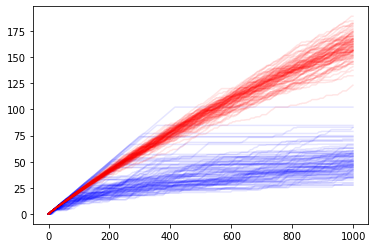

In [37]:
import matplotlib.pyplot as plt

choices = simulator_bucb(process, learning, bucb_selection, N=100, T=1000, K=10, eps=.25, seed=0)
regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * .25, -2)

plt.plot(regret, 'b', alpha=.1);

choices = simulator(process, learning, ucb_selection, N=100, T=1000, K=10, eps=.25, seed=0)
regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * .25, -2)

plt.plot(regret, 'r', alpha=.1);

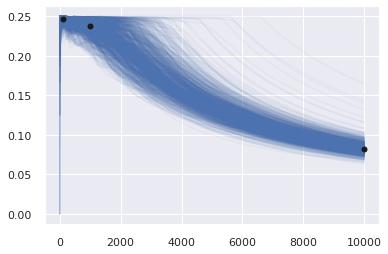

In [105]:
plt.plot(np.cumsum((1 - (choices1 == 0).astype(np.float32)) * eps, 0)/np.arange(1, T+1)[:, None], 'b', alpha=.05);
plt.plot(times, mean_reg['OT_K100'], 'ok')

In [107]:
mean_reg_efe = np.load('res_EFE_Ks_e25.npz')
for K in [3, 10, 100]:
    name = 'EFE_K{}'.format(K)
    mean_reg[name] = mean_reg_efe[name].reshape(len(gammas), len(lambdas), -1)[-1, 4]

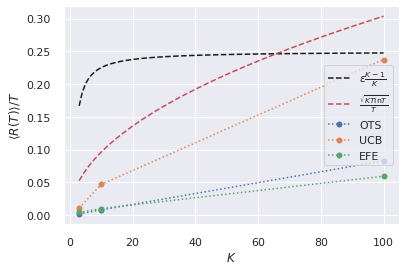

In [117]:
Ks = np.arange(3, 101);
plt.plot(Ks, eps * (Ks - 1)/Ks, 'k--', label=r'$\epsilon\frac{K-1}{K}$');
plt.plot(Ks, np.sqrt(Ks * T * np.log(T))/T, 'r--', label=r'$\frac{\sqrt{K T \ln T}}{T}$');

ot = []
ucb = []
efe = []
for K in [3, 10, 100]:
    ot.append(mean_reg['OT_K{}'.format(K)][-1])
    ucb.append(mean_reg['UCB_K{}'.format(K)][-1])
    efe.append(mean_reg['EFE_K{}'.format(K)][-1])
plt.plot([3, 10, 100], ot, 'o:', label='OTS')
plt.plot([3, 10, 100], ucb, 'o:', label='UCB')
plt.plot([3, 10, 100], efe, 'o:', label='EFE')
plt.xlabel(r'$K$')
plt.ylabel(r'$ \left\langle R(T) \right\rangle /T$')
plt.legend()

In [11]:
lam = .8
gamma = 15.
selection = lambda *args: efe_selection(*args, gamma=gamma, lam=lam)
sequence4 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

lam = .8
gamma = 15.
selection = lambda *args: sup_selection(*args, gamma=gamma, lam=lam)
sequence5 = simulator(process, learning, selection, N=N, T=T, K=K, eps=eps)

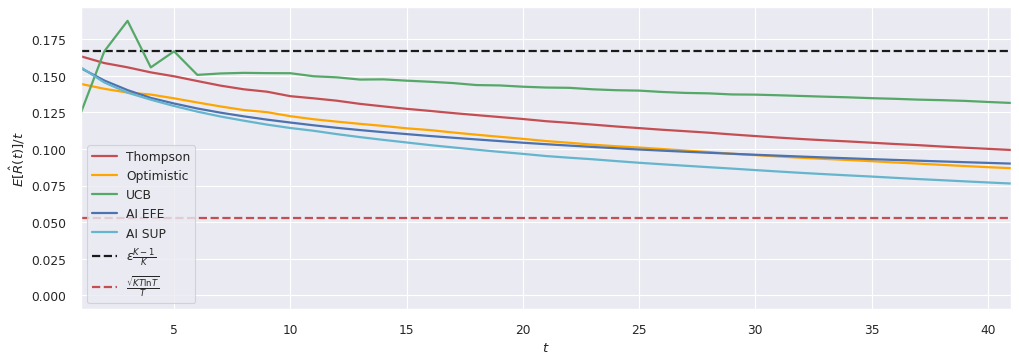

In [12]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([1, 40+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

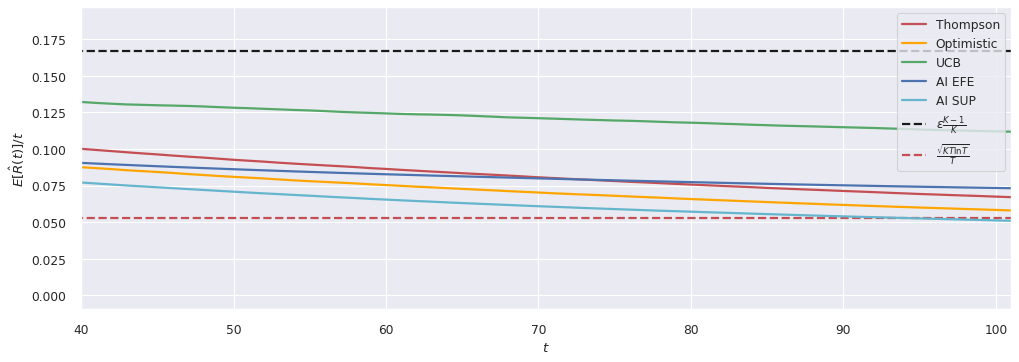

In [15]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([40, 100+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

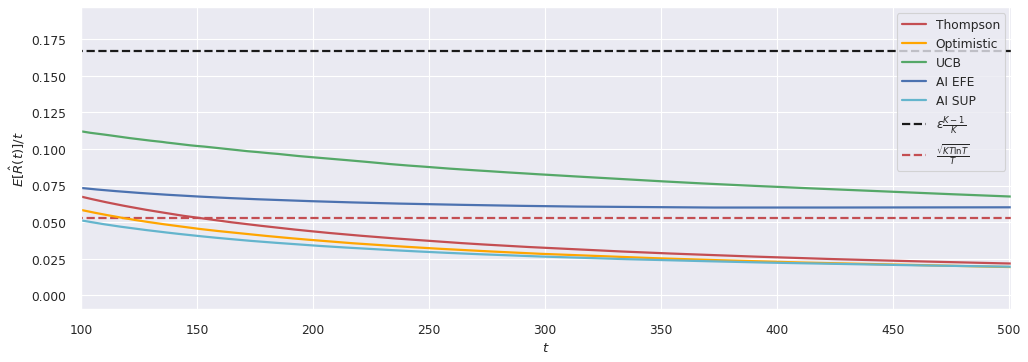

In [16]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([100, 500+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

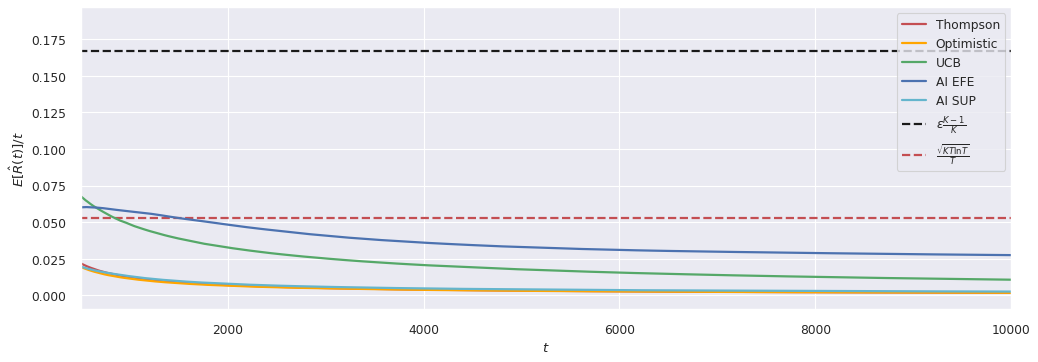

In [17]:
sequences = [sequence1, sequence2, sequence3, sequence4, sequence5]
labels = ['Thompson', 'Optimistic', 'UCB', 'AI EFE', 'AI SUP']
colors = ['r', 'orange', 'g', 'b', 'c']
fig, axes = plt.subplots(1, 1)
ts = np.arange(1., T+1)

max_prob = eps + .5
for i, sequence in enumerate(sequences):
    choices = sequence['choices']
    
    regret = np.cumsum((1 - (choices == 0).astype(np.float32)) * eps, 0)
    plt.plot(regret.mean(-1)/ts, c=colors[i], label=labels[i], lw=2)

plt.hlines(eps * (1 - 1/K), 1, T+1, 'k', linestyle='--', lw=2, label=r'$\epsilon \frac{K-1}{K}$')
plt.hlines(np.sqrt(K * T * np.log(T))/T, 1, T+1, 'r', linestyle='--', lw=2, label=r'$\frac{\sqrt{K T\ln T}}{T}$')
plt.legend();

plt.xlim([500, 10000+1]);
plt.xlabel(r'$t$');
plt.ylabel(r'$E[\hat{R}(t)]/t$');

### TODO:

* establish functional or numerical relationship between $\gamma^*$, $\lambda^*$ and $K$, $\epsilon$.
* for AI SUP algorithm figure out $\gamma^* = f(\lambda, K, \epsilon)$? 
* introduce learning of $\gamma$ and $\lambda$. Would the learning find values of $\lambda$, $\gamma$ that minimize regret?